In [1]:
!pip install hdf5storage

     |████████████████████████████████| 53 kB 575 kB/s eta 0:00:01


In [5]:
#!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
#!bash download_data.sh


    3064


In [59]:
!python mat_to_numpy.py brain_tumor_dataset/

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


### Librairies ###

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import gc
from keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models , losses
from keras.models import load_model
from datetime import datetime
import time 
import tensorflow as tf

#init params
img_size_ori = 512
img_size_target = 128

Init Plugin
Init Graph Optimizer
Init Kernel


### Load Dataset ###

### PreprocessingData Class ###

In [2]:
class PreprocessingData():
    
    def __init__(self):
        
        self.integer_to_class = {'1': 'meningioma', '2': 'glioma', '3': 'pituitary tumor'}
        self.labels = np.load('../brain_tumor_dataset/labels.npy')
        self.images = np.clip( (np.load('../brain_tumor_dataset/images.npy')/12728),0,1)
        self.masks = np.load('../brain_tumor_dataset/masks.npy')*1
        
        self.X = []
        self.X_v = []
        self.Y = []
        self.Y_v = []
        #print(self.labels.shape)
        #print(self.images.shape)
        #print(self.masks.shape)
        #reshape arrays 
        #X = np.stack((X,)*3 , axis = -1)
        
    def getUpDownSampling(self):
        
        self.images = np.expand_dims(self.images,axis=-1)
        self.masks = np.expand_dims(self.masks,axis=-1)
        #self.images = np.stack((self.images,)*3 , axis = -1)
        #self.masks = np.stack((self.masks,)*3 , axis = -1)
        
        def downsample(img):
            if img_size_ori == img_size_target:
                return img
            return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
        def upsample(img):
            if img_size_ori == img_size_target:
                return img
            return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
        self.images = np.array([ downsample(image) for image in self.images ])
        self.masks = (np.array([ downsample(mask) for mask in self.masks ])>0)*1
        
        print(self.images.shape)
        print(self.masks.shape)  
        
        return self.images , self.masks
    
    #Split Data to Two parts Training set and Validation set 
    def splitData(self , size):
        
        self.X,self.X_v,self.Y,self.Y_v = train_test_split(self.images,self.masks,test_size=size,stratify=self.labels)
        gc.collect()
        return self.X,self.X_v,self.Y,self.Y_v
    
    def dataAugmentation(self , batch_s):
        
        self.X = np.append( self.X, [ np.fliplr(x) for x in self.X], axis=0 )
        self.Y = np.append( self.Y, [ np.fliplr(y) for y in self.Y], axis=0 )
        print(self.X.shape , self.Y.shape)
        #Data generation
        train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                           zoom_range=[.9,1.1],
                                           fill_mode='nearest')
        val_datagen = ImageDataGenerator()
        
        train_generator = train_datagen.flow(self.X, self.Y, batch_size=batch_s)
        val_generator = val_datagen.flow(self.X_v, self.Y_v, batch_size=batch_s)
        
        return train_generator , val_generator 
        
        
        
        
        

### Call instance object from PreprocessingData Class ###

In [3]:
#create object instance from preprocessing data class 
processingObject = PreprocessingData()

In [4]:
#get images , masks arrays 
imgs , msks = processingObject.getUpDownSampling()

(3064, 128, 128, 1)
(3064, 128, 128, 1)


#### Plot Labels ####

<BarContainer object of 3 artists>

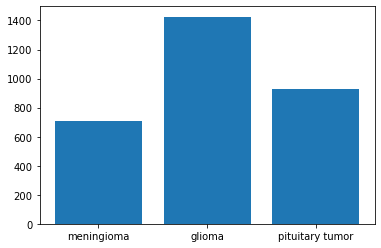

In [5]:
classes, counts = np.unique(processingObject.labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(processingObject.integer_to_class.values()))
#print(counts)
#print(classes)

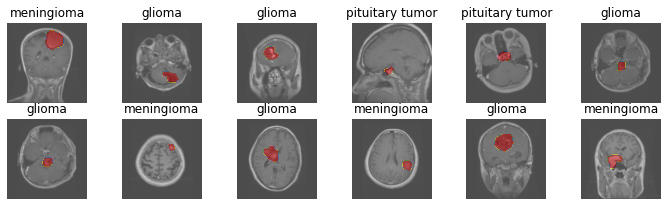

In [6]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(imgs.shape[0], size=12), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(imgs[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(msks[idx])-msks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(processingObject.integer_to_class[str(processingObject.labels[idx])])
    plt.axis('off')

#### Train Image and its mask which is to be predicted ####

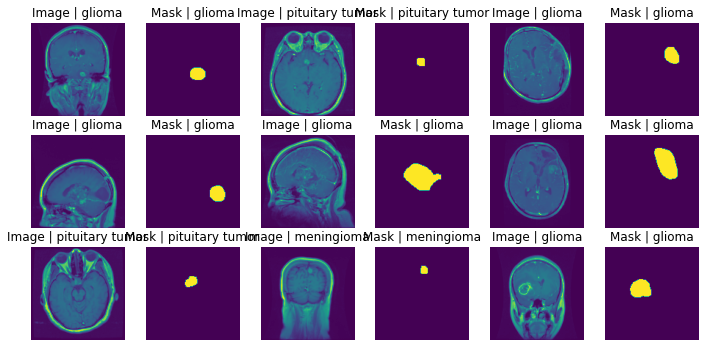

In [7]:
plt.figure(figsize=(12, 12))
i=1
for idx in np.random.randint( imgs.shape[0], size=9):
  plt.subplot(6,6,i);i+=1
  plt.imshow( np.squeeze(imgs[idx],axis=-1))
  plt.title("Image | "+processingObject.integer_to_class[str(processingObject.labels[idx])])
  plt.axis('off')
  plt.subplot(6,6,i);i+=1
  plt.imshow( np.squeeze(msks[idx],axis=-1)) 
  plt.title("Mask | "+processingObject.integer_to_class[str(processingObject.labels[idx])])
  plt.axis('off')

### Split data ###

In [8]:
X,X_v,Y,Y_v = processingObject.splitData(0.2) #20% for validation set 
X.shape,X_v.shape,Y.shape,Y_v.shape

((2451, 128, 128, 1),
 (613, 128, 128, 1),
 (2451, 128, 128, 1),
 (613, 128, 128, 1))

## Load Unet Model ##

In [10]:

unet_model = load_model('../Saved/Brain_Tumor_UNet_50epochs.h5', compile=False) #or compile = False
unet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', losses.dice_coef])


Metal device set to: Apple M1


2022-09-18 01:13:11.616758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-18 01:13:11.617402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Predict Unet Model ##

In [11]:
import random


idx = random.randint(0, len(X))
preds_train = unet_model.predict(X[:int(X.shape[0]*0.9)], verbose=1)
preds_val = unet_model.predict(X[int(X.shape[0]*0.9):], verbose=1)
preds_test = unet_model.predict(X_v, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


2022-09-18 01:13:15.196955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-18 01:13:15.199637: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-18 01:13:19.347487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 75ms/step


In [12]:

ids = [752, 454, 887,100]
temp = np.ones_like( Y_v[0] )
THRESHOLD = 0.5
predicted_mask = (unet_model.predict(X_v)>THRESHOLD)*1

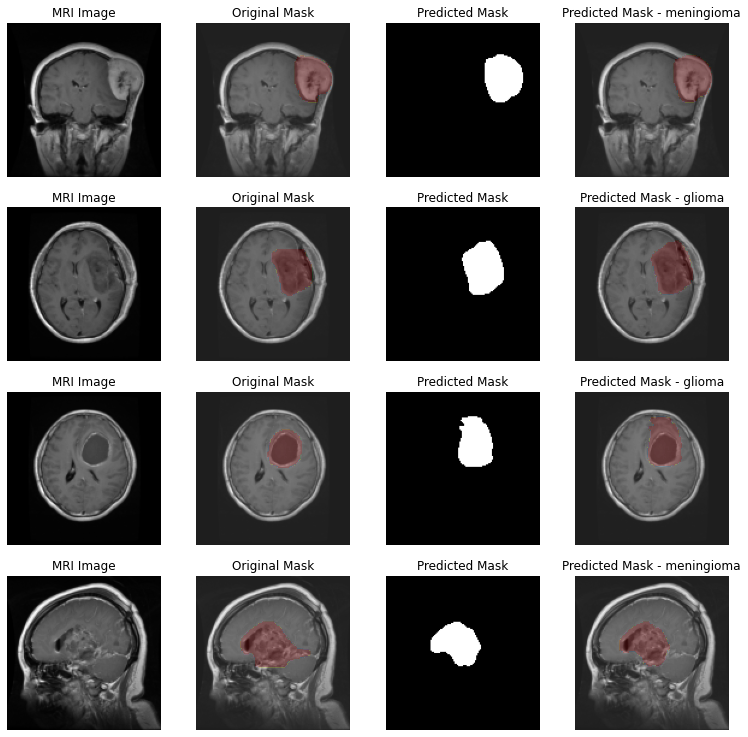

In [15]:

plt.figure(figsize=(13, 13))
j=1
total=4
for i in range(0,len(ids)):
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[i],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(predicted_mask[i],axis=-1), cmap='gray' )
    plt.title("Predicted Mask");plt.axis('off')
    
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[i],axis=-1),  alpha=0.2 ,  cmap='Set1')
    plt.title("Predicted Mask - "+processingObject.integer_to_class[str(processingObject.labels[i])]);plt.axis('off')
    

## Load Unet++ Model ##

In [16]:

unetplus_model = load_model('../Saved/Brain_Tumor_UNet++_50epochs.h5', compile=False) #or compile = False
unetplus_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', losses.dice_coef])

import random


idx = random.randint(0, len(X))
preds_train = unetplus_model.predict(X[:int(X.shape[0]*0.9)], verbose=1)
preds_val = unetplus_model.predict(X[int(X.shape[0]*0.9):], verbose=1)
preds_test = unetplus_model.predict(X_v, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

 1/69 [..............................] - ETA: 50s

2022-09-18 01:16:14.838484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 62ms/step


## Predict Unet++ Model ##

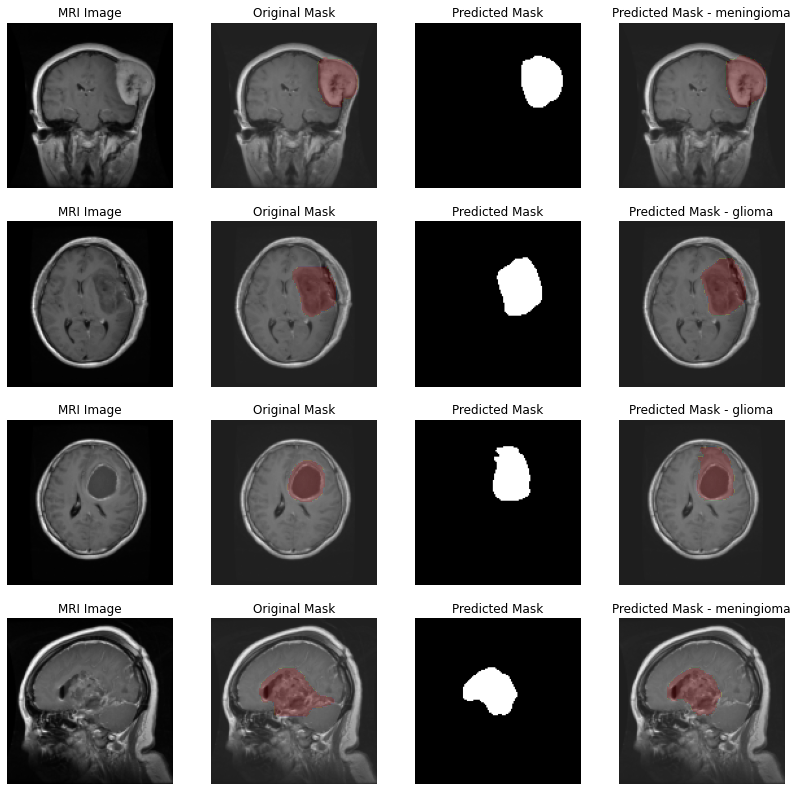

In [17]:

plt.figure(figsize=(14, 14))
j=1
total=4
for i in range(0,len(ids)):
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[i],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(predicted_mask[i],axis=-1), cmap='gray' )
    plt.title("Predicted Mask");plt.axis('off')
    
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[i],axis=-1),  alpha=0.2 ,  cmap='Set1')
    plt.title("Predicted Mask - "+processingObject.integer_to_class[str(processingObject.labels[i])]);plt.axis('off')
    

## Load Attention Unet Model ##

In [18]:

attunet_model = load_model('../Saved/Brain_Tumor_Att_UNet_50epochs.h5', compile=False) #or compile = False
attunet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', losses.dice_coef])

import random


idx = random.randint(0, len(X))
preds_train = attunet_model.predict(X[:int(X.shape[0]*0.9)], verbose=1)
preds_val = attunet_model.predict(X[int(X.shape[0]*0.9):], verbose=1)
preds_test = attunet_model.predict(X_v, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

2022-09-18 01:19:50.221454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 2s 83ms/step


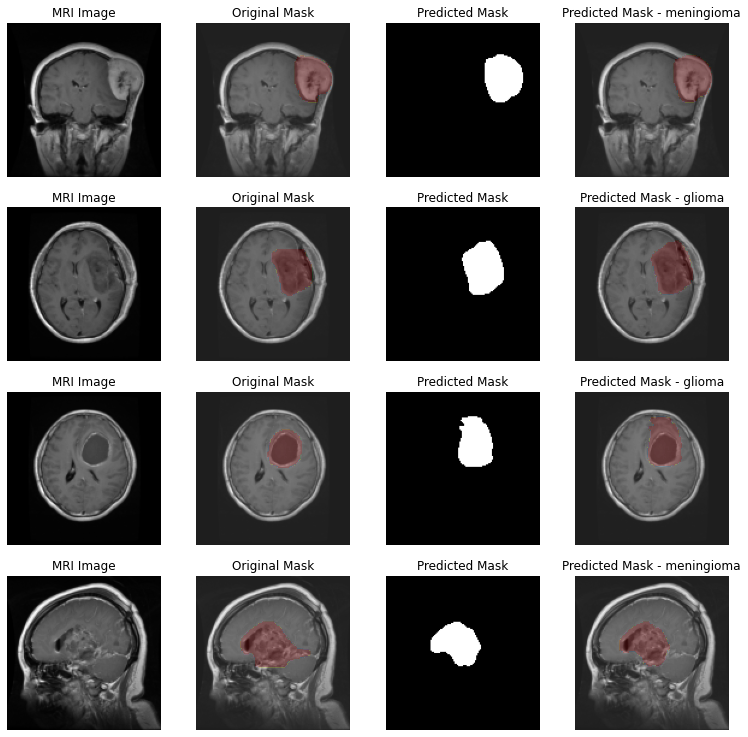

In [19]:

plt.figure(figsize=(13, 13))
j=1
total=4
for i in range(0,len(ids)):
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[i],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(predicted_mask[i],axis=-1), cmap='gray' )
    plt.title("Predicted Mask");plt.axis('off')
    
    plt.subplot(total,4,j);j+=1
    plt.imshow( np.squeeze(X_v[i],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[i],axis=-1),  alpha=0.2 ,  cmap='Set1')
    plt.title("Predicted Mask - "+processingObject.integer_to_class[str(processingObject.labels[i])]);plt.axis('off')
    